In [1]:
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.utils.data import DataLoader, TensorDataset

from models.seq2seq_models.gru_seq2seq import GRUSeq2Seq
from models.seq2seq_models.lstm_seq2seq import LSTMSeq2Seq
from models.seq2seq_models.rnn_seq2seq import RNNSeq2Seq
from models.seq2seq_models.transformer import Transformer, Utils

pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

2025-06-04 23:17:04.868375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 23:17:05.039759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749068225.101862   20114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749068225.122303   20114 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749068225.264823   20114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
data = pd.read_excel('Inshorts Cleaned Data.xlsx', engine='openpyxl')

In [3]:
data.head()

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank of ₹209 crore,"The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had avai...",The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect ...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylhet, Bangladesh","At least three people were killed, including a policeman, while 30 others were wounded on Saturday evening in two explosions in Sylhet, Bangladesh. The explosions were targetted at people and poli...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in futures?,"Mukesh Ambani-led Reliance Industries (RIL) was barred from trading in futures market for a year over stake sale in Reliance Petroleum (RPL). In 2007, RIL sold 4.1% stake in RPL, but shares were f...",Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Times Now: Arnab,"TV news anchor Arnab Goswami has said he was told he could not do the programme two days before leaving Times Now. &#34;18th November was my last day, I was not allowed to enter my own studio,&#34...",YouTube,23:24:00,2017-03-25


In [4]:
data.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
data.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank of ₹209 crore,"The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had avai..."
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect ...
2,"At least 3 killed, 30 injured in blast in Sylhet, Bangladesh","At least three people were killed, including a policeman, while 30 others were wounded on Saturday evening in two explosions in Sylhet, Bangladesh. The explosions were targetted at people and poli..."
3,Why has Reliance been barred from trading in futures?,"Mukesh Ambani-led Reliance Industries (RIL) was barred from trading in futures market for a year over stake sale in Reliance Petroleum (RPL). In 2007, RIL sold 4.1% stake in RPL, but shares were f..."
4,Was stopped from entering my own studio at Times Now: Arnab,"TV news anchor Arnab Goswami has said he was told he could not do the programme two days before leaving Times Now. &#34;18th November was my last day, I was not allowed to enter my own studio,&#34..."


In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
                       "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                       "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
                       "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                       "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                       "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
                       "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                       "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [6]:
stop_words = set(stopwords.words('english'))


def text_cleaner(text):
    new_string = text.lower()
    new_string = BeautifulSoup(new_string, 'lxml').text
    new_string = re.sub(r'\([^)]*\)', '', new_string)
    new_string = re.sub('"', '', new_string)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])
    new_string = re.sub(r"'s\b", "", new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    tokens = [w for w in new_string.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if len(i) >= 3:
            long_words.append(i)
    return (" ".join(long_words)).strip()


cleaned_text = []
for t in data['Short']:
    cleaned_text.append(text_cleaner(t))

In [7]:
data['Headline'][:10]

0      4 ex-bank officials booked for cheating bank of ₹209 crore
1                  Supreme Court to go paperless in 6 months: CJI
2    At least 3 killed, 30 injured in blast in Sylhet, Bangladesh
3           Why has Reliance been barred from trading in futures?
4     Was stopped from entering my own studio at Times Now: Arnab
5                New trailer of &#39;Justice League&#39; released
6     His touch was not right: Shilpa Shinde on sexual harassment
7      Anti-Romeo squads must not trouble consenting youths: Yogi
8        Both Romeo and Juliet are welcome in Delhi: AAP Minister
9         30 blasts occur at ordnance factory in MP,  20 injured 
Name: Headline, dtype: object

In [8]:
def summary_cleaner(text):
    new_string = re.sub('"', '', text)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])
    new_string = re.sub(r"'s\b", "", new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    new_string = new_string.lower()
    tokens = new_string.split()
    new_string = ''
    for i in tokens:
        if len(i) > 1:
            new_string = new_string + i + ' '
    return new_string


cleaned_summary = []
for t in data['Headline']:
    cleaned_summary.append(summary_cleaner(t))

In [9]:
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

In [10]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: '_START_ ' + x + '_END_')
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: '_START_ ' + x + ' _END_')

In [11]:
len(data['cleaned_text']), len(data['cleaned_summary'])

(55101, 55101)

In [12]:
for i in range(5):
    print('Review: ', data['cleaned_text'][i])
    print('Summary: ', data['cleaned_summary'][i])
    print('\n')

Review:  _START_ cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing crore loss state run bank accused availed home loans credit syndicate bank basis forged fabricated documents funds fraudulently transferred companies owned accused persons _END_
Summary:  _START_ ex bank officials booked for cheating bank of crore _END_


Review:  _START_ chief justice khehar said supreme court paperless six seven months bid save funds make judiciary eco friendly said apex court collect records electronically lower courts high courts need file hard copies _END_
Summary:  _START_ supreme court to go paperless in months cji _END_


Review:  _START_ least three people killed including policeman others wounded saturday evening two explosions sylhet bangladesh explosions targetted people police officials witnessing hour long gunfight extremists commandos earlier friday man blown front checkpoint near dhaka airport _END_
Summary:  _START_ at least

In [13]:
data = data.reset_index()

In [14]:
data

,index,Headline,Short,cleaned_text,cleaned_summary
0,0,4 ex-bank officials booked for cheating bank of ₹209 crore,"The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had avai...",_START_ cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing crore loss state run bank accused availed home loans credit syndicate bank ...,_START_ ex bank officials booked for cheating bank of crore _END_
1,1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect ...,_START_ chief justice khehar said supreme court paperless six seven months bid save funds make judiciary eco friendly said apex court collect records electronically lower courts high courts need f...,_START_ supreme court to go paperless in months cji _END_
2,2,"At least 3 killed, 30 injured in blast in Sylhet, Bangladesh","At least three people were killed, including a policeman, while 30 others were wounded on Saturday evening in two explosions in Sylhet, Bangladesh. The explosions were targetted at people and poli...",_START_ least three people killed including policeman others wounded saturday evening two explosions sylhet bangladesh explosions targetted people police officials witnessing hour long gunfight ex...,_START_ at least killed injured in blast in sylhet bangladesh _END_
3,3,Why has Reliance been barred from trading in futures?,"Mukesh Ambani-led Reliance Industries (RIL) was barred from trading in futures market for a year over stake sale in Reliance Petroleum (RPL). In 2007, RIL sold 4.1% stake in RPL, but shares were f...",_START_ mukesh ambani led reliance industries barred trading futures market year stake sale reliance petroleum ril sold stake rpl shares first short sold futures market avoid fall rpl stocks short...,_START_ why has reliance been barred from trading in futures _END_
4,4,Was stopped from entering my own studio at Times Now: Arnab,"TV news anchor Arnab Goswami has said he was told he could not do the programme two days before leaving Times Now. &#34;18th November was my last day, I was not allowed to enter my own studio,&#34...",_START_ news anchor arnab goswami said told could programme two days leaving times november last day allowed enter studio goswami added build institution allowed enter studio feel sad journalist s...,_START_ was stopped from entering my own studio at times now arnab _END_
...,...,...,...,...,...
55096,55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the benchmark Sensex on Wednesday slipped by around 400 points during early trade to hit a 52-week low of 24101.50. Meanwhile, the broader Nifty tanked b...",_START_ tracking weak cues asian markets benchmark sensex wednesday slipped around points early trade hit week low meanwhile broader nifty tanked points lowest level since june rupee tumbled paise...,_START_ sensex loses points to hit week low _END_
55097,55100,China to inject $91 bn into the money markets,"Amid growing concerns about China&#39;s economic growth rate, the country&#39;s central bank, the People&#39;s Bank of China, said on Tuesday it would inject over $91.22 billion into the money mar...",_START_ amid growing concerns china economic growth rate country central bank people bank china said tuesday would inject billion money markets comes china reported weakest economic growth years c...,_START_ china to inject bn into the money markets _END_
55098,55101,Ghulam Ali set to make acting debut in Bollywood,"Pakistani Ghazal singer Ghulam Ali will soon make his acting debut in Bollywood with the film &#39;Ghar Wapsi&#39;, directed by Suhaib Ilyasi. The singer, who was in Delhi on Tuesday to dub for th.

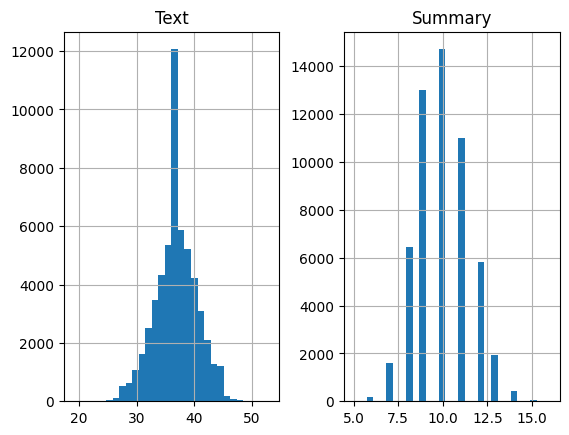

In [15]:
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
    text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Text': text_word_count, 'Summary': summary_word_count})
length_df.hist(bins=30)
plt.show()

In [16]:
text_word_count = np.array(text_word_count)
summary_word_count = np.array(summary_word_count)
print(f'Text | Mean: {text_word_count.mean()} | Std: {text_word_count.std()} | Min: {text_word_count.min()} | Max: {text_word_count.max()}')
print(f'Summary | Mean: {summary_word_count.mean()} | Std: {summary_word_count.std()} | Min: {summary_word_count.min()} | Max: {summary_word_count.max()}')

Text | Mean: 36.758026170123955 | Std: 3.5999541317316677 | Min: 19 | Max: 53
Summary | Mean: 9.980581114680314 | Std: 1.4477413777575552 | Min: 5 | Max: 16


In [17]:
max_len_text = 50
max_len_summary = 10

In [18]:
data[['cleaned_text', 'cleaned_summary']]

,cleaned_text,cleaned_summary
0,_START_ cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing crore loss state run bank accused availed home loans credit syndicate bank ...,_START_ ex bank officials booked for cheating bank of crore _END_
1,_START_ chief justice khehar said supreme court paperless six seven months bid save funds make judiciary eco friendly said apex court collect records electronically lower courts high courts need f...,_START_ supreme court to go paperless in months cji _END_
2,_START_ least three people killed including policeman others wounded saturday evening two explosions sylhet bangladesh explosions targetted people police officials witnessing hour long gunfight ex...,_START_ at least killed injured in blast in sylhet bangladesh _END_
3,_START_ mukesh ambani led reliance industries barred trading futures market year stake sale reliance petroleum ril sold stake rpl shares first short sold futures market avoid fall rpl stocks short...,_START_ why has reliance been barred from trading in futures _END_
4,_START_ news anchor arnab goswami said told could programme two days leaving times november last day allowed enter studio goswami added build institution allowed enter studio feel sad journalist s...,_START_ was stopped from entering my own studio at times now arnab _END_
...,...,...
55096,_START_ tracking weak cues asian markets benchmark sensex wednesday slipped around points early trade hit week low meanwhile broader nifty tanked points lowest level since june rupee tumbled paise...,_START_ sensex loses points to hit week low _END_
55097,_START_ amid growing concerns china economic growth rate country central bank people bank china said tuesday would inject billion money markets comes china reported weakest economic growth years c...,_START_ china to inject bn into the money markets _END_
55098,_START_ pakistani ghazal singer ghulam ali soon make acting debut bollywood film ghar wapsi directed suhaib ilyasi singer delhi tuesday dub film said keep three four days actor guess singing easy ...,_START_ ghulam ali set to make acting debut in bollywood _END_
55099,_START_ islamic state acknowledged death jihadi john british masked militant appearing videos depicting beheadings western hostages site intelligence group reported tuesday published eulogy englis...,_START_ is acknowledges death of jihadi john report _END_


In [19]:
reduced_data = data[data['cleaned_text'].str.split().str.len() <= max_len_text]
reduced_data = reduced_data[reduced_data['cleaned_summary'].str.split().str.len() <= max_len_summary]
reduced_data

,index,Headline,Short,cleaned_text,cleaned_summary
1,1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect ...,_START_ chief justice khehar said supreme court paperless six seven months bid save funds make judiciary eco friendly said apex court collect records electronically lower courts high courts need f...,_START_ supreme court to go paperless in months cji _END_
5,5,New trailer of &#39;Justice League&#39; released,"A new trailer for the upcoming superhero film &#39;Justice League&#39; was released on Saturday. Based on the DC Comics superhero team, the film stars Ben Affleck as &#39;Batman&#39;, Gal Gadot as...",_START_ new trailer upcoming superhero film justice league released saturday based comics superhero team film stars ben affleck batman gal gadot wonder woman ezra miller flash jason momoa aquaman ...,_START_ new trailer of justice league released _END_
9,9,"30 blasts occur at ordnance factory in MP, 20 injured",At least 20 people were reportedly injured after over 30 blasts occurred at an ordnance factory in Madhya Pradesh&#39;s Jabalpur on Saturday evening. Nearly 50 fire tenders were rushed to the Ordn...,_START_ least people reportedly injured blasts occurred ordnance factory madhya pradesh jabalpur saturday evening nearly fire tenders rushed ordnance factory khamaria rescue trapped victims access...,_START_ blasts occur at ordnance factory in mp injured _END_
12,12,Thousands march in London to protest against Brexit,"Thousands of people on Saturday took to the streets in London to protest against the UK&#39;s decision to leave the European Union. Demanding continuation of benefits of remaining in the EU, the p...",_START_ thousands people saturday took streets london protest decision leave european union demanding continuation benefits remaining protesters said voted remain referendum brexit process initiat...,_START_ thousands march in london to protest against brexit _END_
13,13,US brewer MillerCoors sues HCL Technologies for ₹650 crore,"Indian IT major HCL Technologies is being sued by US-based brewer MillerCoors, which has alleged the former did not deliver an enterprise software project on agreed timelines. MillerCoors, which i...",_START_ indian major hcl technologies sued based brewer millercoors alleged former deliver enterprise software project agreed timelines millercoors client company sued hcl tech million according r...,_START_ us brewer millercoors sues hcl technologies for crore _END_
...,...,...,...,...,...
55095,55098,Rupee hits 28-month low of 68.05 against Dollar,The Indian rupee tumbled 30 paise to trade over 28-month low at 68.05 against the US dollar in early trade on Wednesday. Analysts attributed the fall to strong demand for the dollar from importers...,_START_ indian rupee tumbled paise trade month low dollar early trade wednesday analysts attributed fall strong demand dollar importers banks amid lower opening domestic equity market rupee hit re...,_START_ rupee hits month low of against dollar _END_
55096,55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the benchmark Sensex on Wednesday slipped by around 400 points during early trade to hit a 52-week low of 24101.50. Meanwhile, the broader Nifty tanked b...",_START_ tracking weak cues asian markets benchmark sensex wednesday slipped around points early trade hit week low meanwhile broader nifty tanked points lowest level since june rupee tumbled paise...,_START_ sensex loses points to hit week low _END_
55097,55100,China to inject $91 bn into the money markets,"Amid growing concerns about China&#39;s economic growth rate, the country&#39;s central bank, the People&#39;s Bank of China, said on Tuesday it would inject over $91.22 billion into the money mar...",_START_ amid growing concerns china economic g

In [20]:
x_tr, x_val, y_tr, y_val = train_test_split(reduced_data['cleaned_text'], reduced_data['cleaned_summary'], test_size=0.1,
                                            random_state=0, shuffle=True)

In [21]:
x_tr.index, y_tr.index

(Index([37511, 40431,  8101, 12071, 45548, 15338, 35207, 49635, 34618, 19040,
        ...
        51010, 33771, 30694, 31697, 31061, 38059, 50867, 48967, 38615,  7750],
       dtype='int64', length=32322),
 Index([37511, 40431,  8101, 12071, 45548, 15338, 35207, 49635, 34618, 19040,
        ...
        51010, 33771, 30694, 31697, 31061, 38059, 50867, 48967, 38615,  7750],
       dtype='int64', length=32322))

In [22]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1

In [23]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

In [24]:
y_tokenizer.index_word[5]

'for'

In [25]:
y_tr

array([[    2,   230,   480, ...,   663,     1,     0],
       [    2,   239,  1551, ...,   777,     1,     0],
       [    2,    96,  1045, ...,  1011,    69,     1],
       ...,
       [    2, 10618,    94, ...,     0,     0,     0],
       [    2, 21664,   387, ...,   580,     1,     0],
       [    2,   560,  4271, ...,     7,   823,     1]], dtype=int32)

In [26]:
y_tokenizer.index_word[1]

'end'

In [27]:
train_data = TensorDataset(torch.from_numpy(x_tr).long(), torch.from_numpy(y_tr).long())
val_data = TensorDataset(torch.from_numpy(x_val).long(), torch.from_numpy(y_val).long())
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)

In [28]:
def accuracy(outputs, targets):
    flattened_outputs = outputs.argmax(dim=-1).flatten()
    flattened_targets = targets[:, 1:].flatten()
    accuracies = flattened_outputs.eq(flattened_targets)
    mask = torch.logical_not(flattened_outputs.eq(0))
    accuracies = torch.logical_and(mask, accuracies)
    return (accuracies.sum() / mask.sum()).item()

In [29]:
def train_and_validate(model_, optimizer_, criterion_, train_loader_, val_loader_, epochs_, device_, model_type='rnn'):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs_):
        model_.train()
        total_train_loss = 0
        for (inputs, targets) in train_loader_:
            inputs, targets = inputs.to(device_), targets.to(device_)
            outputs = model_(inputs, targets[:, :-1])
            loss = criterion_(outputs.flatten(start_dim=0, end_dim=1), targets[:, 1:].flatten())
            total_train_loss += loss.item()
            optimizer_.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_.parameters(), 1.0)
            optimizer_.step()

        model_.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader_:
                inputs, targets = inputs.to(device_), targets.to(device_)
                if model_type == 'transformer':
                    outputs = model_(inputs, targets[:, :-1])
                else:
                    outputs = model_(inputs, targets[:, :-1], 0)
                loss = criterion_(outputs.flatten(start_dim=0, end_dim=1), targets[:, 1:].flatten())
                total_val_loss += loss.item()
                total_val_acc += accuracy(outputs, targets)

        total_train_loss = total_train_loss / len(train_loader_)
        total_val_loss = total_val_loss / len(val_loader_)
        total_val_acc = total_val_acc / len(val_loader_)

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)
        val_accs.append(total_val_acc)
        print(
            f'Epoch: {epoch + 1} / {epochs_} | Train loss: {total_train_loss} | Val loss: {total_val_loss} | Val acc: {total_val_acc}')
    return train_losses, val_losses, val_accs


In [30]:
def plot_losses(model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [31]:
target_word_index = y_tokenizer.word_index
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word

In [32]:
def decode_sequence(input_seq, model_, rnn_type='rnn'):
    model_.eval()
    with torch.no_grad():
        if rnn_type == 'lstm':
            enc_output, hidden, cell_state = model_.encoder(torch.IntTensor(input_seq).to(device))
        else:
            enc_output, hidden = model_.encoder(torch.IntTensor(input_seq).to(device))
    
        target_seq = torch.zeros(1, dtype=torch.int64).to(device)
        target_seq[0] = target_word_index['start']
    
        stop_condition = False
        decoded_sentence = ''
        while not stop_condition:
            if rnn_type == 'lstm':
                prediction, hidden, _ = model_.decoder(target_seq, enc_output, hidden, cell_state)
            else:
                prediction, hidden = model_.decoder(target_seq, enc_output, hidden)
            prediction_index = prediction.argmax(dim=-1)[0].item()
            predicted_word = reverse_target_word_index[prediction_index]
    
            if predicted_word != 'end':
                decoded_sentence += ' ' + predicted_word
    
            if predicted_word == 'end' or len(decoded_sentence.split()) >= max_len_summary - 1:
                stop_condition = True
    
            target_seq = torch.zeros(1, dtype=torch.int64).to(device)
            target_seq[0] = prediction_index
    
        return decoded_sentence


In [33]:
def seq2summary(input_seq):
    new_string = ''
    for i in input_seq:
        if (i != 0 and i != target_word_index['start']) and i != target_word_index['end']:
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string


def seq2text(input_seq):
    new_string = ''
    for i in input_seq:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string


# RNN Seq2Seq

In [34]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [50]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.540727577661809 | Val loss: 7.172283846756508 | Val acc: 0.12907088059803534
Epoch: 2 / 10 | Train loss: 7.172573398695633 | Val loss: 7.165870354093355 | Val acc: 0.12574832424007612
Epoch: 3 / 10 | Train loss: 7.0226448929828145 | Val loss: 7.222741488752694 | Val acc: 0.12613745136507626
Epoch: 4 / 10 | Train loss: 6.871032686572772 | Val loss: 7.1694856676562075 | Val acc: 0.12380268219216116
Epoch: 5 / 10 | Train loss: 6.736644933346232 | Val loss: 7.208010541981664 | Val acc: 0.12619731780783883
Epoch: 6 / 10 | Train loss: 6.631843103250496 | Val loss: 7.213496602814773 | Val acc: 0.1266463126601844
Epoch: 7 / 10 | Train loss: 6.517722110974459 | Val loss: 7.249893056935277 | Val acc: 0.12652658054540897
Epoch: 8 / 10 | Train loss: 6.40316398153192 | Val loss: 7.315606824282942 | Val acc: 0.12628711580202498
Epoch: 9 / 10 | Train loss: 6.304288473996249 | Val loss: 7.296719090691928 | Val acc: 0.12616738471491584
Epoch: 10 

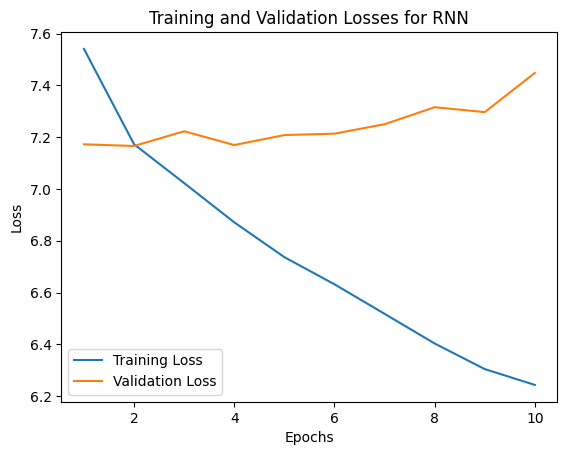

In [51]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [52]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   new to to in today


# RNN Seq2Seq With Attention

In [53]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [54]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.494507388163933 | Val loss: 6.955622886789256 | Val acc: 0.1364343875441058
Epoch: 2 / 10 | Train loss: 6.648131668332066 | Val loss: 6.304612554352859 | Val acc: 0.15505268065066174
Epoch: 3 / 10 | Train loss: 5.900305693328616 | Val loss: 5.893410024971797 | Val acc: 0.1716954024701283
Epoch: 4 / 10 | Train loss: 5.244248478780151 | Val loss: 5.718978602310707 | Val acc: 0.17660440658700877
Epoch: 5 / 10 | Train loss: 4.658450264233374 | Val loss: 5.562301569971545 | Val acc: 0.1861230823500403
Epoch: 6 / 10 | Train loss: 4.1059775644611465 | Val loss: 5.546663958450844 | Val acc: 0.1860033538320969
Epoch: 7 / 10 | Train loss: 3.6088917556958706 | Val loss: 5.569789228768184 | Val acc: 0.18579382243855247
Epoch: 8 / 10 | Train loss: 3.1678630250244746 | Val loss: 5.584276626849997 | Val acc: 0.18854765337089013
Epoch: 9 / 10 | Train loss: 2.7947710059848228 | Val loss: 5.625422740804738 | Val acc: 0.18636254760725746
Epoch: 10 

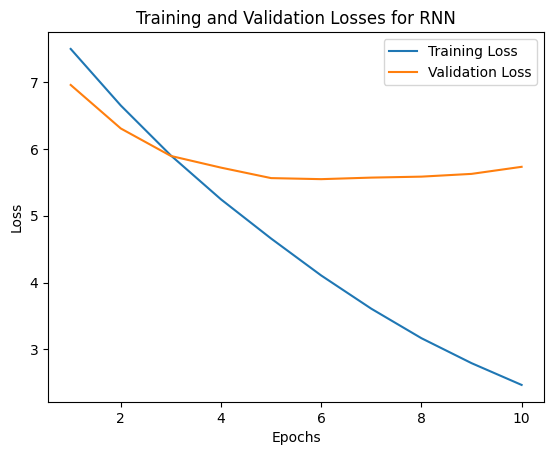

In [55]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [56]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   hafiz attack pak to to pak taliban


# RNN Seq2Seq With Attention and BiDirectional Encoder

In [57]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True, encoder_modes='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [58]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.3971974538720175 | Val loss: 6.7007244866469815 | Val acc: 0.14278017267070967
Epoch: 2 / 10 | Train loss: 6.326330490263083 | Val loss: 6.009295562217975 | Val acc: 0.16579861116820369
Epoch: 3 / 10 | Train loss: 5.476831711328077 | Val loss: 5.657729806571171 | Val acc: 0.17884937750882116
Epoch: 4 / 10 | Train loss: 4.764341640849358 | Val loss: 5.528215342554553 | Val acc: 0.1825610630471131
Epoch: 5 / 10 | Train loss: 4.1226377044270635 | Val loss: 5.4619349117936755 | Val acc: 0.18666187853648744
Epoch: 6 / 10 | Train loss: 3.54751684166226 | Val loss: 5.467304903885414 | Val acc: 0.1872306029344427
Epoch: 7 / 10 | Train loss: 3.0482352373628276 | Val loss: 5.533295730064655 | Val acc: 0.1866020118368083
Epoch: 8 / 10 | Train loss: 2.6296944297820684 | Val loss: 5.581829843849971 | Val acc: 0.18585368888131504
Epoch: 9 / 10 | Train loss: 2.28226829329027 | Val loss: 5.686071330103381 | Val acc: 0.1832495223859261
Epoch: 10 

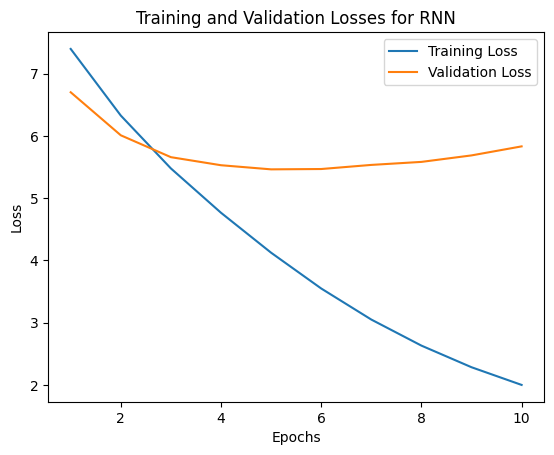

In [59]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [60]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   mastermind hafiz pak to military military


# LSTM Seq2Seq

In [69]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [70]:
print('LSTMSeq2Seq Start Training:')
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

LSTMSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.9014378046329785 | Val loss: 7.089352673497693 | Val acc: 0.1298491369033682
Epoch: 2 / 10 | Train loss: 7.133343915223133 | Val loss: 7.039538695894438 | Val acc: 0.1252394619173017
Epoch: 3 / 10 | Train loss: 7.043170058208963 | Val loss: 7.048306646018193 | Val acc: 0.12485033581996786
Epoch: 4 / 10 | Train loss: 6.983443060411295 | Val loss: 7.07099671199404 | Val acc: 0.12529932964464713
Epoch: 5 / 10 | Train loss: 6.94130318343875 | Val loss: 7.049562750191524 | Val acc: 0.12646671435956297
Epoch: 6 / 10 | Train loss: 6.894388253509763 | Val loss: 7.058244080379091 | Val acc: 0.1266163795672614
Epoch: 7 / 10 | Train loss: 6.844134447602887 | Val loss: 7.060481466096023 | Val acc: 0.12754430056645952
Epoch: 8 / 10 | Train loss: 6.759317371685043 | Val loss: 7.054430123033194 | Val acc: 0.1293702110134322
Epoch: 9 / 10 | Train loss: 6.668964252170367 | Val loss: 7.041715950801454 | Val acc: 0.13008860113291904
Epoch: 10 / 10

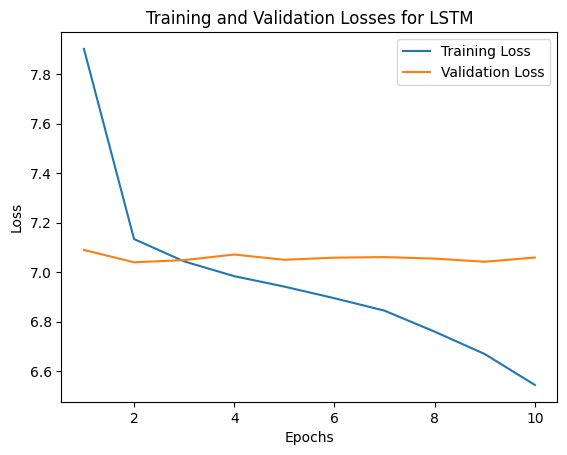

In [71]:
plot_losses('LSTM', lstm_train_losses, lstm_val_losses, epochs)

In [72]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, rnn_type='lstm'))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   killed in in in in in in in in


# LSTM Seq2Seq With Attention

In [73]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [74]:
print('LSTMSeq2Seq Start Training:')
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

LSTMSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.630385523257048 | Val loss: 7.055558566389413 | Val acc: 0.12535919557357655
Epoch: 2 / 10 | Train loss: 7.097678872436402 | Val loss: 7.037638565589642 | Val acc: 0.12841235563672823
Epoch: 3 / 10 | Train loss: 7.006991629543983 | Val loss: 7.013564126244907 | Val acc: 0.12574832321240983
Epoch: 4 / 10 | Train loss: 6.9335681157621 | Val loss: 7.006678219499259 | Val acc: 0.12814295959883723
Epoch: 5 / 10 | Train loss: 6.848794801433096 | Val loss: 6.981561134601462 | Val acc: 0.12934027714975949
Epoch: 6 / 10 | Train loss: 6.739118095443183 | Val loss: 6.990057451971646 | Val acc: 0.1310763898594626
Epoch: 7 / 10 | Train loss: 6.597467324479295 | Val loss: 6.973347976289946 | Val acc: 0.13107638857487974
Epoch: 8 / 10 | Train loss: 6.433652977698405 | Val loss: 7.0077447397955535 | Val acc: 0.1306573275862069
Epoch: 9 / 10 | Train loss: 6.257277731838905 | Val loss: 7.024489353443014 | Val acc: 0.1325730362842823
Epoch: 10 / 1

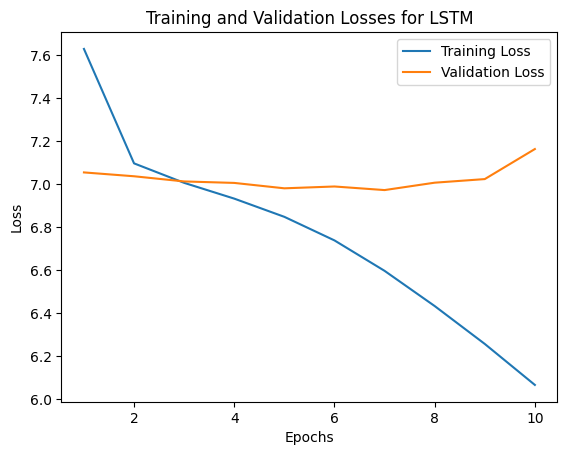

In [75]:
plot_losses('LSTM', lstm_train_losses, lstm_val_losses, epochs)

In [76]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, 'lstm'))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   pak to to of in of of in of


# LSTM Seq2Seq With Attention and BiDirectional Encoder

In [77]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True, encoder_modes='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [78]:
print('LSTMSeq2Seq Start Training:')
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

LSTMSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.64222773073219 | Val loss: 7.144546114165207 | Val acc: 0.1252693970655573
Epoch: 2 / 10 | Train loss: 7.1190266138008935 | Val loss: 7.025170211134286 | Val acc: 0.12658644570358868
Epoch: 3 / 10 | Train loss: 7.023100268699435 | Val loss: 7.040555098961139 | Val acc: 0.12568845754039698
Epoch: 4 / 10 | Train loss: 6.938593990717952 | Val loss: 7.008206351050015 | Val acc: 0.12922054709031663
Epoch: 5 / 10 | Train loss: 6.964627710726893 | Val loss: 6.962831842488256 | Val acc: 0.1299988031387329
Epoch: 6 / 10 | Train loss: 6.696565633705953 | Val loss: 6.895769957838388 | Val acc: 0.13068725990838018
Epoch: 7 / 10 | Train loss: 6.50638937102005 | Val loss: 6.891965076841157 | Val acc: 0.1335308914040697
Epoch: 8 / 10 | Train loss: 6.297310804661084 | Val loss: 6.846426207443764 | Val acc: 0.13538673468704882
Epoch: 9 / 10 | Train loss: 6.073047157332831 | Val loss: 6.849393203340727 | Val acc: 0.13442887853959512
Epoch: 10 / 1

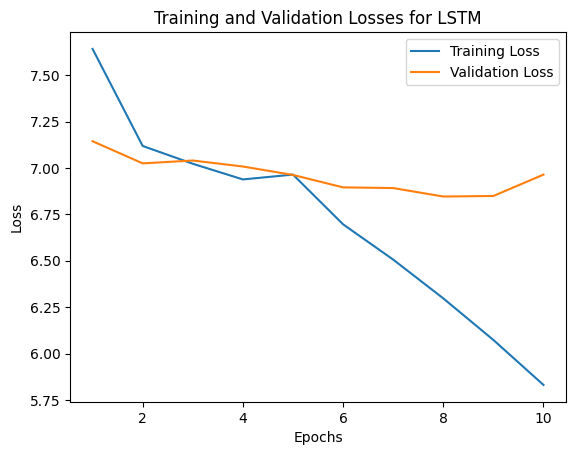

In [79]:
plot_losses('LSTM', lstm_train_losses, lstm_val_losses, epochs)

In [80]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, 'lstm'))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   pak suspends in in


# GRU Seq2Seq

In [81]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [82]:
print('GRUSeq2Seq Start Training:')
gru_train_losses, gru_val_losses, gru_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

GRUSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.436424460806865 | Val loss: 6.955780226608803 | Val acc: 0.13077705867331604
Epoch: 2 / 10 | Train loss: 6.684434114237548 | Val loss: 6.326199252029945 | Val acc: 0.14984434740296726
Epoch: 3 / 10 | Train loss: 5.975636216491578 | Val loss: 5.943863802942737 | Val acc: 0.1594228929486768
Epoch: 4 / 10 | Train loss: 5.302528912842038 | Val loss: 5.71654984046673 | Val acc: 0.16427202933821186
Epoch: 5 / 10 | Train loss: 4.6452266406636 | Val loss: 5.632536888122559 | Val acc: 0.17058788394105845
Epoch: 6 / 10 | Train loss: 4.02256670770909 | Val loss: 5.608064388406688 | Val acc: 0.16909123494707304
Epoch: 7 / 10 | Train loss: 3.419229601682882 | Val loss: 5.6576171250178895 | Val acc: 0.16726532629851637
Epoch: 8 / 10 | Train loss: 2.9108901334845503 | Val loss: 5.723837030344996 | Val acc: 0.16771431986627908
Epoch: 9 / 10 | Train loss: 2.4889363959843935 | Val loss: 5.857436048573461 | Val acc: 0.16044061425431022
Epoch: 10 / 

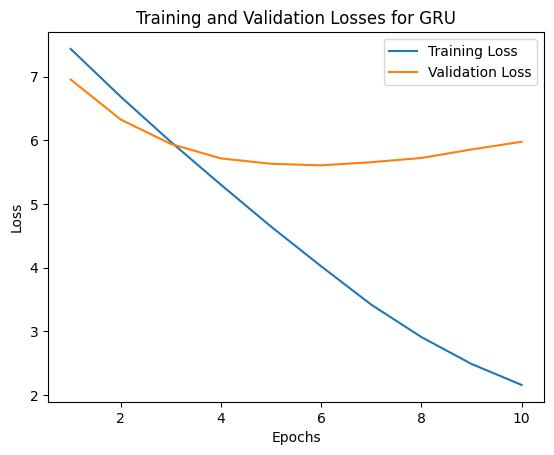

In [83]:
plot_losses('GRU', gru_train_losses, gru_val_losses, epochs)

In [84]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, rnn_type='gru'))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   pakistan attack urges to against attack attack


# GRU Seq2Seq With Attention

In [85]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [86]:
print('GRUSeq2Seq Start Training:')
gru_train_losses, gru_val_losses, gru_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

GRUSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.390067228686668 | Val loss: 6.778366138195169 | Val acc: 0.13544659933139538
Epoch: 2 / 10 | Train loss: 6.489945134626547 | Val loss: 6.1412184156220535 | Val acc: 0.1546934873893343
Epoch: 3 / 10 | Train loss: 5.712085599484651 | Val loss: 5.796863309268294 | Val acc: 0.16768438703027264
Epoch: 4 / 10 | Train loss: 4.943750317388844 | Val loss: 5.564704122214482 | Val acc: 0.17747246294186034
Epoch: 5 / 10 | Train loss: 4.1693857705640225 | Val loss: 5.482377644242911 | Val acc: 0.18202227045749797
Epoch: 6 / 10 | Train loss: 3.434985091092558 | Val loss: 5.495869932503536 | Val acc: 0.1875897985080193
Epoch: 7 / 10 | Train loss: 2.7921821656434433 | Val loss: 5.593942987507787 | Val acc: 0.178639847142943
Epoch: 8 / 10 | Train loss: 2.2846645941376216 | Val loss: 5.731042187789391 | Val acc: 0.17256345779731355
Epoch: 9 / 10 | Train loss: 1.8874113423079841 | Val loss: 5.853201290656781 | Val acc: 0.1775323275862069
Epoch: 10 

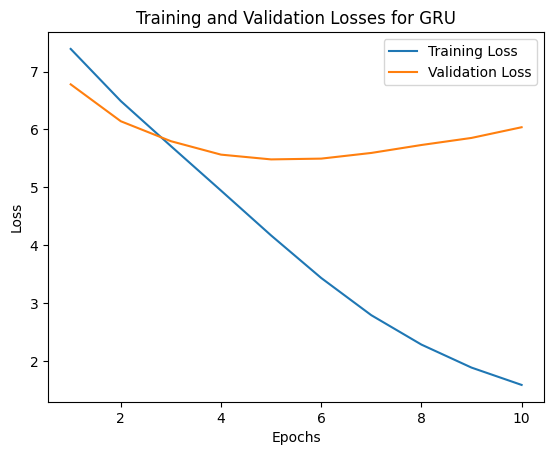

In [87]:
plot_losses('GRU', gru_train_losses, gru_val_losses, epochs)

In [88]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, 'gru'))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   mastermind saeed military military attack to pak attack


# GRU Seq2Seq With Attention and BiDirectional Encoder

In [89]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True, encoder_modes='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [90]:
print('GRUSeq2Seq Start Training:')
gru_train_losses, gru_val_losses, gru_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

GRUSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 7.506988515966966 | Val loss: 7.117301414752829 | Val acc: 0.1251496646938653
Epoch: 2 / 10 | Train loss: 7.120587669342403 | Val loss: 6.843195010875833 | Val acc: 0.13451867833219724
Epoch: 3 / 10 | Train loss: 6.606549683295691 | Val loss: 6.308233211780417 | Val acc: 0.15301724137931033
Epoch: 4 / 10 | Train loss: 6.013824217875484 | Val loss: 5.975982633130304 | Val acc: 0.16352370741038486
Epoch: 5 / 10 | Train loss: 5.439403850570498 | Val loss: 5.7982521879261935 | Val acc: 0.16977969248747005
Epoch: 6 / 10 | Train loss: 4.867897461525536 | Val loss: 5.639005430813493 | Val acc: 0.179358237776263
Epoch: 7 / 10 | Train loss: 4.291264473685163 | Val loss: 5.570273119827797 | Val acc: 0.17825071667802744
Epoch: 8 / 10 | Train loss: 3.721904592551733 | Val loss: 5.59595093233832 | Val acc: 0.1813936778183641
Epoch: 9 / 10 | Train loss: 3.184530594603346 | Val loss: 5.620442768623089 | Val acc: 0.17947796706495614
Epoch: 10 / 10

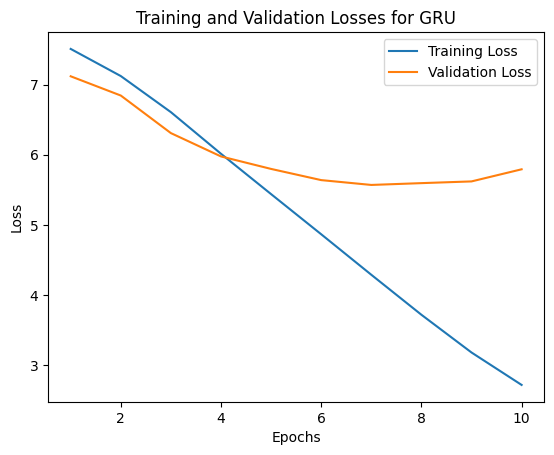

In [91]:
plot_losses('GRU', gru_train_losses, gru_val_losses, epochs)

In [92]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:   hafiz asks to military to attack attack attack


# Transformer

In [44]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(enc_vocab_size=enc_vocab_size, 
                    dec_vocab_size=dec_vocab_size, 
                    enc_len_seq=max_len_text, 
                    dec_len_seq=max_len_summary - 1, 
                    embedding_dim=embedding_dim, 
                    enc_depth=enc_layers, 
                    dec_depth=dec_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [45]:
print('Transformer Start Training:')
transformer_train_losses, transformer_val_losses, transformer_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device, model_type='transformer')

Transformer Start Training:
Epoch: 1 / 10 | Train loss: 6.931956996088442 | Val loss: 5.936653531830887 | Val acc: 0.19043342871912594
Epoch: 2 / 10 | Train loss: 5.37813605432925 | Val loss: 5.3462618137228075 | Val acc: 0.22790948378628698
Epoch: 3 / 10 | Train loss: 4.298980599806714 | Val loss: 5.119374456076787 | Val acc: 0.24799449176623903
Epoch: 4 / 10 | Train loss: 3.479026324192997 | Val loss: 5.086517333984375 | Val acc: 0.25730363510805987
Epoch: 5 / 10 | Train loss: 2.8578037141340054 | Val loss: 5.167051430406241 | Val acc: 0.2607159958831195
Epoch: 6 / 10 | Train loss: 2.3770510999581558 | Val loss: 5.260568224150559 | Val acc: 0.27203065413853217
Epoch: 7 / 10 | Train loss: 1.9932573506012266 | Val loss: 5.4791867321935195 | Val acc: 0.26601413149258185
Epoch: 8 / 10 | Train loss: 1.6950967410807554 | Val loss: 5.625781684086241 | Val acc: 0.2697856791060546
Epoch: 9 / 10 | Train loss: 1.460251403891522 | Val loss: 5.764989228084169 | Val acc: 0.2756226057636327
Epoch: 

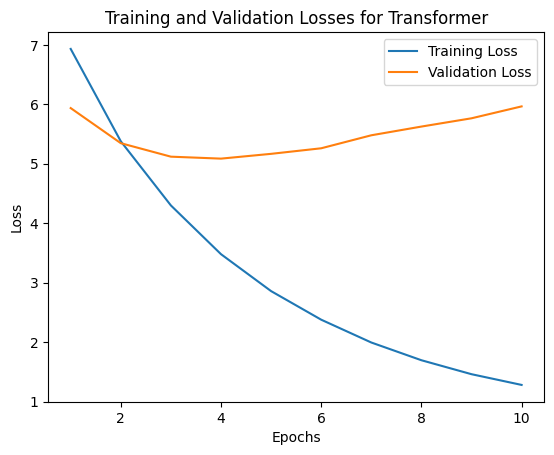

In [46]:
plot_losses('Transformer', transformer_train_losses, transformer_val_losses, epochs)

In [47]:
def decode_sequence(input_seq, model_):
    model_.eval()
    with torch.no_grad():
        input_seq = torch.IntTensor(input_seq).to(device)
        target_seq = torch.zeros((1,1), dtype=torch.int64).to(device)
        target_seq[:, 0] = target_word_index['start']
        padding = torch.zeros((1, 8), dtype=torch.int64).to(device)
        target_seq = torch.cat((target_seq, padding), 1)
    
        decoded_sentence = ''
        for idx in range(max_len_summary - 2):
            trg_mask = Utils.make_combined_mask(target_seq)
            prediction = model_(input_seq, target_seq, look_ahead_mask=trg_mask)
            prediction_index = prediction.argmax(dim=-1)[0][idx].item()
            predicted_word = reverse_target_word_index[prediction_index]
    
            if predicted_word != 'end':
                target_seq[:, idx + 1] = prediction_index
                decoded_sentence += ' ' + predicted_word
    
            if predicted_word == 'end' or len(decoded_sentence.split()) >= max_len_summary - 1:
                break
    
        return decoded_sentence.replace('start', '').replace('end', '').strip()

In [50]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    print('\n')
    if i == 0:
        break

Review:  start alleged mumbai attack mastermind hafiz saeed friday asked pakistan military shoot american drones enter country comes first visit special representative afghanistan pakistan visit islamabad recent drone strike killed afghan taliban leader mullah akhtar mansour pakistan termed attack violation sovereignty end 
Original summary:  shoot down us drones entering pak hafiz saeed 
Predicted summary:  hafiz saeed threatens pakistan visit to afghanistan


